In [5]:
%pylab inline

from sklearn.datasets import fetch_openml

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop

from tqdm._tqdm_notebook import tqdm_notebook

#from PIL import Image

import tensorflow as tf
import xml.etree.ElementTree as ET 
import os
import cv2

rcParams['axes.grid'] = True
rcParams['figure.figsize'] = (10,6)

Populating the interactive namespace from numpy and matplotlib


In [6]:
def read_image(src):
    img = cv2.imread(src)
    if img is None:
        raise FileNotFoundError
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

image_width = 64
image_height = 64
image_channels = 3
image_sample_size = 10000

def crop_image(path):
    image = read_image(path)
    tree = ET.parse(os.path.join(annotation_dir, '/'.join(path.split('/')[-2:])[:-4]))
    
    root = tree.getroot() 
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    objects = root.findall('object')
    
    bndbox = objects[0].find('bndbox') 

    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    # 4 : margin
    xmin = max(0, xmin - 4) 
    xmax = min(width, xmax + 4)
    ymin = max(0, ymin - 4)
    ymax = min(height, ymax + 4)

    # available w
    w = np.min((xmax - xmin, ymax - ymin))
    w = min(w, width, height)                     

    if w > xmax - xmin:
        xmin = min(max(0, xmin - int((w - (xmax - xmin))/2)), width - w)
        xmax = xmin + w
    if w > ymax - ymin:
        ymin = min(max(0, ymin - int((w - (ymax - ymin))/2)), height - w)
        ymax = ymin + w

    # [h,w,c]
    img_cropped = image[ymin:ymin+w, xmin:xmin+w, :]    

    # Interpolation method
    if xmax - xmin > image_width:
        # shrink
        interpolation = cv2.INTER_AREA          
    else:
        # expansion
        interpolation = cv2.INTER_CUBIC         

    # resize
    return cv2.resize(img_cropped, (image_width, image_height), interpolation=interpolation)

In [7]:
annotation_dir = 'stanford-dogs-dataset/annotations/Annotation'
image_dir = 'stanford-dogs-dataset/images/Images'
dog_breed_dict = {}
for annotation in os.listdir(annotation_dir):
    if annotation == '.DS_Store':
        continue
    annotations = annotation.split('-')
    dog_breed_dict[annotations[0]] = '-'.join(annotations[1:])

In [8]:
images = {}
for tag, breed in tqdm_notebook(dog_breed_dict.items()):
    breed_dir = '{}/{}-{}'.format(image_dir, tag, breed)
    fnames = ['{}/{}'.format(breed_dir, fname) for fname in os.listdir(breed_dir)]
    images[tag] = np.array([crop_image(fname) for fname in fnames])

In [171]:
train_per_breed = 80
test_per_breed = 50

X_train = np.zeros(shape=(len(images)*train_per_breed,image_height,image_width,image_channels))
X_test  = np.zeros(shape=(len(images)*test_per_breed,image_height,image_width,image_channels))
y_train = np.zeros(shape=(len(images)*train_per_breed))
y_test  = np.zeros(shape=(len(images)*test_per_breed))
breed_category = []
for breed_idx, kv in enumerate(images.items()):
    breed, image_arr = kv
    idx_lo_train = breed_idx*train_per_breed
    idx_lo_test  = breed_idx*test_per_breed
    indices = np.random.randint(len(image_arr),size=(train_per_breed+test_per_breed))
    X_train[idx_lo_train : idx_lo_train+train_per_breed, :,:,:] = image_arr[indices[:train_per_breed]]
    X_test[idx_lo_test : idx_lo_test+test_per_breed, :,:,:] = image_arr[indices[train_per_breed:]]
    y_train[idx_lo_train : idx_lo_train + train_per_breed] = breed_idx
    y_test[idx_lo_test : idx_lo_test + test_per_breed] = breed_idx
    breed_category.append(dog_breed_dict[breed])

In [172]:
X_train = (X_train - 127.5)/255
X_test  = (X_test - 127.5)/255
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)

In [173]:
def conv(model, out_channels, ksize, stride_size):
    model.add(Conv2D(out_channels,(ksize,ksize),strides=(stride_size,stride_size),padding='same',use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(leaky_relu_slope))
    model.add(Dropout(0.40))
    return model

In [232]:
leaky_relu_slope = 0.20

# Do rounds of Conv2D, doubling filters, applying batch normalization, and leaky relu.

model = Sequential()
model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same', use_bias=False, 
                 input_shape=(image_height, image_width, image_channels)))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha=leaky_relu_slope))
model.add(Dropout(0.50))

model = conv(model, 64, ksize=4, stride_size=2)
model = conv(model, 128, ksize=4, stride_size=2)
model = conv(model, 256, ksize=4, stride_size=2)

model.add(Flatten())
model.add(Dense(len(dog_breed_dict), activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 32, 32, 64)        3072      
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 64)        65536     
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)      

In [234]:
losses = [[],[]]

In [282]:
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [302]:
history = model.fit(X_train,y_train,epochs=100,batch_size=64,validation_data=(X_test,y_test))
losses[0] += history.history['accuracy']
losses[1] += history.history['val_accuracy']

Train on 9600 samples, validate on 6000 samples
Epoch 1/100
9600/9600 [==============================] - 27s 3ms/sample - loss: 1.1898 - accuracy: 0.7150 - val_loss: 3.1443 - val_accuracy: 0.3965
Epoch 2/100
9600/9600 [==============================] - 26s 3ms/sample - loss: 1.1845 - accuracy: 0.7142 - val_loss: 3.1469 - val_accuracy: 0.3968
Epoch 3/100
9600/9600 [==============================] - 26s 3ms/sample - loss: 1.1838 - accuracy: 0.7116 - val_loss: 3.1498 - val_accuracy: 0.3965
Epoch 4/100
9600/9600 [==============================] - 26s 3ms/sample - loss: 1.1737 - accuracy: 0.7188 - val_loss: 3.1433 - val_accuracy: 0.3985
Epoch 5/100
9600/9600 [==============================] - 26s 3ms/sample - loss: 1.1706 - accuracy: 0.7175 - val_loss: 3.1454 - val_accuracy: 0.3978
Epoch 6/100
9600/9600 [==============================] - 26s 3ms/sample - loss: 1.1785 - accuracy: 0.7106 - val_loss: 3.1454 - val_accuracy: 0.3997
Epoch 7/100
9600/9600 [==============================] - 26s 3ms

Epoch 56/100
9600/9600 [==============================] - 27s 3ms/sample - loss: 0.9553 - accuracy: 0.7706 - val_loss: 3.1359 - val_accuracy: 0.4150
Epoch 57/100
9600/9600 [==============================] - 27s 3ms/sample - loss: 0.9617 - accuracy: 0.7704 - val_loss: 3.1305 - val_accuracy: 0.4148
Epoch 58/100
9600/9600 [==============================] - 27s 3ms/sample - loss: 0.9623 - accuracy: 0.7711 - val_loss: 3.1334 - val_accuracy: 0.4143
Epoch 59/100
9600/9600 [==============================] - 27s 3ms/sample - loss: 0.9392 - accuracy: 0.7790 - val_loss: 3.1361 - val_accuracy: 0.4150
Epoch 60/100
9600/9600 [==============================] - 27s 3ms/sample - loss: 0.9405 - accuracy: 0.7768 - val_loss: 3.1348 - val_accuracy: 0.4142
Epoch 61/100
9600/9600 [==============================] - 27s 3ms/sample - loss: 0.9563 - accuracy: 0.7732 - val_loss: 3.1294 - val_accuracy: 0.4153
Epoch 62/100
9600/9600 [==============================] - 27s 3ms/sample - loss: 0.9406 - accuracy: 0.7772

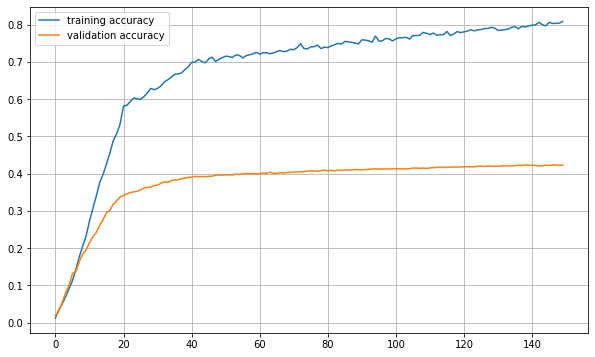

In [303]:
plot(losses[0],label='training accuracy')
plot(losses[1],label='validation accuracy')
legend(loc='upper left')

In [304]:
model.save('dog.h5')

In [364]:
tests = []
for fname in ['mac1.jpg','mac2.jpg','maltese.jpg']:
    tests.append(cv2.resize(read_image('stanford-dogs-dataset/{}'.format(fname)), 
                            (image_width, image_height), interpolation=cv2.INTER_AREA))

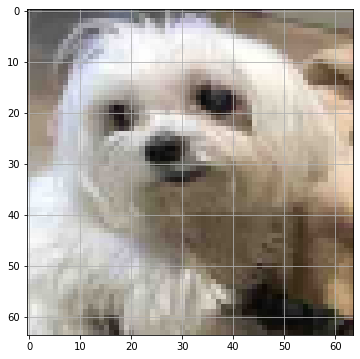

In [362]:
imshow(tests[1])

<BarContainer object of 5 artists>

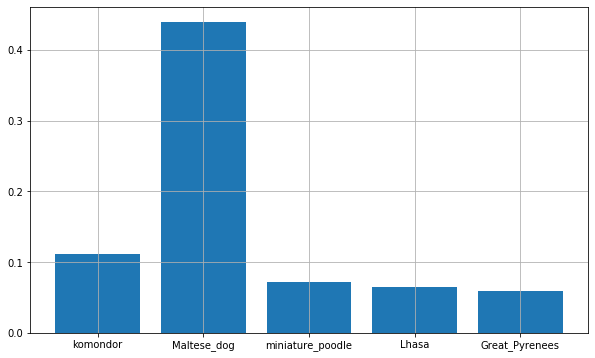

In [363]:
prediction = model.predict((tests[1].reshape(1,64,64,3) - 127.5)/255)[0]
cutoff = prediction > np.sort(prediction)[-6:].min()
bar(np.array(breed_category)[cutoff],prediction[cutoff])